# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from tqdm import tqdm
import os
from time import time
from datetime import datetime
import json

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

# Lots of code in misc
from misc import *

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(no_graphics=True, file_name="./Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while 0:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    print(action)
    if done:                                       # exit loop if episode finished
        break    
    print("Score: {}".format(score))

### 4. Train DQN agents
Beyond training a single agent to solve the task, we extend the goal to a comparison between [vanilla DQN](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf) and [double DQN](https://arxiv.org/abs/1509.06461). The idea is to run each algorithm `n_rpt` times and compare the average performance. Since each run of 600 episodes takes about 350s, it's useful to save each result to disk and simply load it when running the notebook again. We also save the `n_rpt` random seeds to a file and re-use them since we want to have the same seeds when comparing the two algorithms and we don't want them re-generated when running the notebook again. 

In [6]:
# Set some useful parameters, including the seeds used for the test
solved_score = 13
n_episodes = 600
n_rpt = 10
seeds_path = "seeds.np"
device = check_cuda(0)

# We'll need a folder to save all the trained models so we don't have to retrain each time we run the code
if not os.path.isdir("./temp"):
    os.mkdir("./temp")

# We want the same seeds, just in case we run the notebook again and want to re-use old results
if os.path.isfile(seeds_path):
    print("Using saved random seeds from {}".format(seeds_path))
    seeds = np.loadtxt(seeds_path, dtype=np.int32)
else:
    seeds = np.random.randint(0,1e4, size=(n_rpt))
    np.savetxt(seeds_path, seeds, fmt="%d")

CUDA is available!  Training on GPU ...
Using GeForce GTX 1080 Ti
Using saved random seeds from seeds.np


In [122]:
from dqn_agent import Agent

arch_names = ["DQN","DoubleDQN"]
n_arch = len(arch_names)
arch_params = {"DQN": {"double": False}, "DoubleDQN": {"double": True}}

all_scores = np.zeros((n_rpt, len(arch_names), n_episodes))
solved_in = np.zeros((n_rpt, len(arch_names)))

# Train agents
for i, arch in enumerate(arch_names):
    for j, seed in enumerate(seeds):
        t_start = time()
        # First we check if we already trained this agent or not
        save_path = get_model_save_path(arch, n_episodes, seed)
        if not os.path.isfile(save_path):
            print("Architecture {} seed {} started at {}".format(i+1, j+1, datetime.now()), end="")
            # Initialize a new agent with the corresponding random (but presaved) seed
            agent = Agent(device, state_size=state_size, action_size=action_size, 
                                  seed=seed, double=arch_params[arch]["double"])
            
            # Run DQN
            agent, scores, _ = dqn(agent, env, solved_score, 
                                                   n_episodes=n_episodes, verbose=False)
            
            # Save model and performance figures
            torch.save(agent.qnetwork_local.state_dict(), save_path)
            np.savetxt(get_scores_save_path(arch, n_episodes, seed), scores, fmt="%f")
            print("... DONE in {:.3f} s".format(time() - t_start))
        else:
            # If we trained the agent, let's load the results
            print("Loading architecture {} seed {} from file".format(i+1, j+1))
            all_scores[j, i] = np.loadtxt(get_scores_save_path(arch, n_episodes, seed), dtype=np.float64)
            
            # Now let's find at which episode the environment was solved 
            # Note that below center=False -> this is because we take the average over the last 100 episodes
            smoothed = pd.Series(all_scores[j, i]).rolling(100, center=False).mean()
            try:
                solved_in[j, i] = np.nonzero(np.array(smoothed) >= solved_score)[0][0]
            except IndexError:
                solved_in[j, i] = np.nan
                print("\tNote: Environment was not solved!")

Loading architecture 1 seed 1 from file
Loading architecture 1 seed 2 from file
	Note: Environment was not solved!
Loading architecture 1 seed 3 from file
Loading architecture 1 seed 4 from file
Loading architecture 1 seed 5 from file
Loading architecture 1 seed 6 from file
Loading architecture 1 seed 7 from file
Loading architecture 1 seed 8 from file
Loading architecture 1 seed 9 from file
Loading architecture 1 seed 10 from file
Loading architecture 2 seed 1 from file
Loading architecture 2 seed 2 from file
Loading architecture 2 seed 3 from file
Loading architecture 2 seed 4 from file
Loading architecture 2 seed 5 from file
Loading architecture 2 seed 6 from file
Loading architecture 2 seed 7 from file
Loading architecture 2 seed 8 from file
Loading architecture 2 seed 9 from file
Loading architecture 2 seed 10 from file


/home/mircea/anaconda3/envs/drl/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater_equal


It looks like in one vanilla DQN repetition, the environment wasn't solved in 600 episodes! 

Before we proceed, let's save the weights of the best performing agent from each algorithm in the root directory, as the project asks. We will use the last 100 episodes as our benchmark. 

In [200]:
for i, arch in enumerate(arch_names):
    best_score = -np.inf
    for j, seed in enumerate(seeds):
        save_path = get_model_save_path(arch, n_episodes, seed)
        if np.mean(all_scores[j, i, -100:]) >= best_score:
            best_score = np.mean(all_scores[j, i, -100:])
            best_score_path = save_path
    # Now save the weights to file
    torch.save(torch.load(best_score_path), "Best_{}_agent.pth".format(arch))

### 5. Analyze performance
Let's take a look at the agent's performance in random repetitions. We will also show the *trend* of the data by smoothing it with a window 100 episodes long that's *centered* on the current data point (episode). Note that this is different from the requirement to solve the environment - in that case the current episode is the *last* data point in the sliding window. 

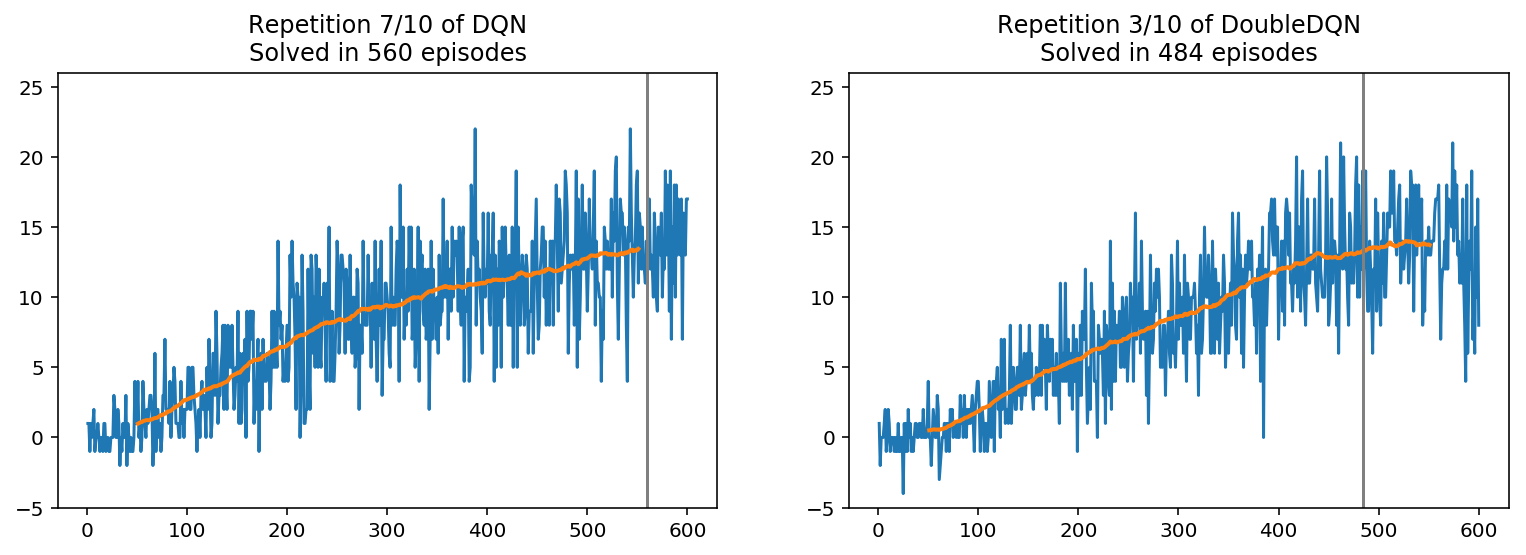

In [203]:
scores = all_scores

n_smooth = 100
x = np.arange(1,n_episodes+1)
fig, ax = plt.subplots(1, len(arch_names), figsize=(13, 4))
for i, arch in enumerate(arch_names):
    which_rpt = np.random.randint(n_rpt)
    y = scores[which_rpt, i,:]
    ax[i].plot(x,y)
    ax[i].plot(x,pd.Series(y).rolling(n_smooth, center=True).mean(), linewidth=2)
    ax[i].set_ylim([-5,26])
    # Show where the environment was solved 
    ax[i].plot([solved_in[which_rpt, i], solved_in[which_rpt, i]], [-5,26], color='gray')
    if not np.isnan(solved_in[which_rpt, i]):
        ax[i].set_title("Repetition {}/{} of {}\nSolved in {} episodes".format(
                                                    which_rpt+1, n_rpt, arch, int(solved_in[which_rpt, i])))
    else:
        ax[i].set_title("Repetition {}/{} of {}\nEnvironment not solved!".format(which_rpt+1, n_rpt, arch))
        
# Also save figure for the report
plt.savefig("Single-run performance.png", dpi=600)

Above, the vertical gray bar is the episode at which the environment was solved. Running the cell multiple times suggests that double DQN does solve the environment faster.

Let's see the mean and standard deviation of the two algorithms for all 10 repetitions and get a more general view on performance. We will also show on average, at which episode was the environment solved, for each algorithm. 

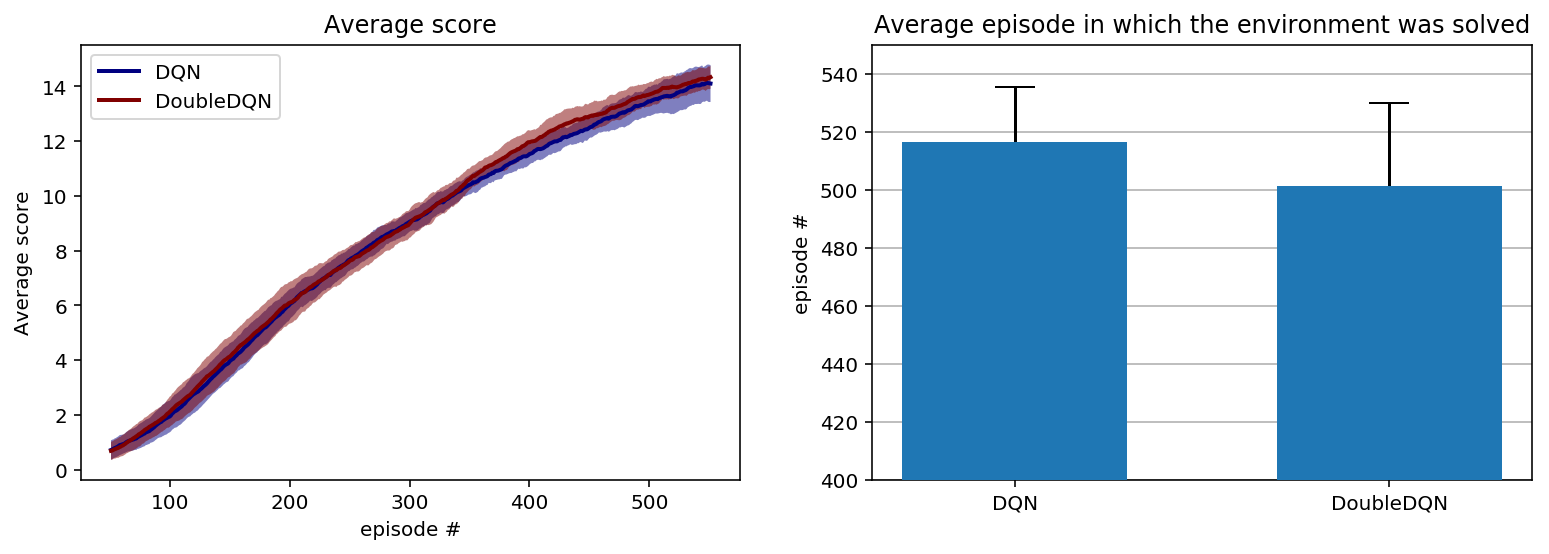

In [205]:
smoothed = smooth_scores(all_scores, n_smooth=100)

cmap = plt.cm.get_cmap("jet", len(arch_names))
x = np.arange(1, n_episodes+1)
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
for i, arch in enumerate(arch_names):
    mu1 = np.mean(smoothed[:,i,:], axis=0)
    sigma1 = np.std(smoothed[:,i,:], axis=0)
    ax[0].plot(x, mu1, lw=2, label=arch, color=cmap(i))
    ax[0].fill_between(x, mu1+sigma1, mu1-sigma1, facecolor=cmap(i), alpha=0.5)
    ax[0].set_title("Average score")
    ax[0].legend(loc='upper left')
    ax[0].set_xlabel('episode #')
    ax[0].set_ylabel('Average score');    

# Show at which episode the environment was solved on average
ax[1].bar(arch_names, [np.nanmean(solved_in[:,0]), np.nanmean(solved_in[:,1])], 
          yerr=[np.nanstd(solved_in[:,0]), np.nanstd(solved_in[:,1])], width=0.6, zorder=3, capsize=10)
ax[1].set_ylim([400,550])
ax[1].set_ylabel("episode #")
ax[1].yaxis.grid(True)
ax[1].set_title("Average episode in which the environment was solved");

# Also save figure for the report
plt.savefig("Average performance.png", dpi=600)

We can see double DQN performing a bit better on average than the vanilla DQN. The difference does not seem significant though, as the performance of double DQN is less consistent - see the larger standard deviation in the bar plot. That said, there does seem to be a trend toward faster learning of double DQN starting with episode 350 onward. And let us remember that in one repetition, vanilla DQN didn't even solve the environment in the allocated 600 episodes!

While I expected double DQN to provide vastly better performance, it is worth noting that in the [double DQN paper](https://arxiv.org/abs/1509.06461) there were a few Atari games in which vanilla DQN actually performed better, for instance Chopper Command, Time Pilot, Robotank, and Assault. I think that a more complex task would widen the performance gap. 

### 6. Potential improvements
Double DQN has already proven itself a potential improvement for our banana-collecting agent. I've only looked at double DQN because it's extremely simple to implement - it's just another line of code. Other improvements might be:
- [Prioritized experience replay](https://arxiv.org/abs/1511.05952). This one I think would improve performance dramatically. The idea behind it is very simple: instead of uniformly sampling from the experience replay buffer, why not prioritize experiences from which the agent learned more? The easy way is to achieve it is to scale the probabilities by the TD error. 
- [Dueling DQN](https://arxiv.org/abs/1511.06581). Dueling DQN architectures decouple the values of states and actions. Certain states are better than others without even considering the possible action choices. The dueling architecture allows the network to take advantage of this.
- Hyperparameter search. This is almost guaranteed to improve results but it's time consuming and perhaps not as interesting as implementing various proposed improvements. 
- Architectural improvements to the network, such as [Kaiming](https://arxiv.org/abs/1502.01852) weight initialization and [batch normalization layers](https://arxiv.org/abs/1502.03167).

In [9]:
# Close the environment when we're done
env.close()